In [1]:
#This notebook performs live inference on an audio file recorded on PC
#results are shown for a clip where I pretended to snore
#model was trained on apnea+snore / healthy task

import sys

import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter,filtfilt
import librosa
import librosa.display

import torch
import torchvision
from torch.autograd import Variable
from torchvision.io import read_image
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import time

import sounddevice as sd
import soundfile as sf

In [2]:
#low-pass filtering function
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [3]:
def predict_image(image, model):
    image_tensor = image.float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = F.sigmoid(output).data.cpu().numpy()
    return index

In [4]:
device = torch.device('cuda')
print("GPU name: ", torch.cuda.get_device_name(0))
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.fc = torch.nn.Linear(512, 1) #just 1 output, will use sigmoid later
PATH = './models/model.pth' #load the saved weights
resnet18.load_state_dict(torch.load(PATH))
resnet18.eval() #set eval mode
resnet18.to(device)

GPU name:  NVIDIA GeForce RTX 2060


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
###########################################################################
#this section records an audio clip
samplerate = 44100  # Hertz
duration = 3  # seconds
filename = 'output_snore.wav'
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate, channels=1, blocking=True)
sf.write(filename, mydata, samplerate)
###########################################################################

total_start_time = time.time()

Fs, samples = wavfile.read(filename)
total_seconds = int(len(samples)/Fs)

for second in range(0, 1, 1): #go through every second rolling window
    
    x = samples[(second)*Fs:(second+60)*Fs] #take out the selected minute

    cutoff = 1000 #define filter cutoff frequency (1000Hz)
    order = 5 #define filter order
    x_filtered = butter_lowpass_filter(x, cutoff, Fs, order) #low-pass filtering

    x_downsampled = signal.resample(x_filtered, 2048*60) #downsample the function to 2kHz
    new_Fs = 2048
    
    n_fft = 512 #length of fft, 512 optimal for speech

    sgram = librosa.stft(x_downsampled, center=False, n_fft=n_fft)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=new_Fs, n_fft=n_fft)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    #for raw graphs to save
    #librosa.display.specshow(mel_sgram, sr=Fs, n_fft=n_fft, fmin=22, fmax=700)
    #for graphs with axis and scale
    librosa.display.specshow(mel_sgram, sr=new_Fs*4, n_fft=n_fft, fmin=22, fmax=700)
    #plt.colorbar(format='%+2.0f dB')
    file = 'output_snore.jpg'
    #print(file)
    plt.savefig(file) #need to save the figure as a jpg
    
    spectrogram_end_time = time.time()
    
    plt.close()
    img = cv2.imread(file) #re-open the file to crop off white space
    img = img[34:253, 53:390]
    cv2.imwrite(file, img)

C:\Users\Skyler\anaconda3\envs\edge\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


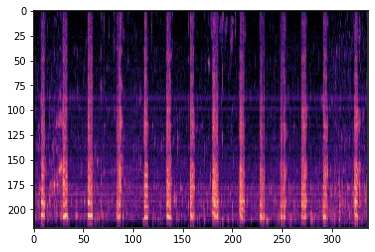

0.71056336
0=healthy 1=apnea/snore - result:  1
Inference time (seconds):  0.01894688606262207
Total time (seconds):  0.31238222122192383
Spectrogram time (seconds):  0.2784769535064697


In [6]:
img_path = 'output_snore.jpg'
image = read_image(img_path)

total_end_time = time.time()

result = predict_image(image, resnet18)[0][0] #first inference is very slow, skip in timing

inference_start_time = time.time() #measure the time for inference only

result = predict_image(image, resnet18)[0][0]

inference_end_time = time.time()

#display selected image, done after timing completed
img = image.permute(1,2,0)
plt.imshow(img)
plt.show()

print(result)
print("0=healthy 1=apnea/snore - result: ", round(result))
print("Inference time (seconds): ", inference_end_time-inference_start_time)
print("Total time (seconds): ", total_end_time-total_start_time + inference_end_time-inference_start_time)
print("Spectrogram time (seconds): ", spectrogram_end_time-total_start_time)